# Lecture 14 - Batch RL

provided by [Stanford CS234](https://www.youtube.com/watch?v=FgzM3zpZ55o)

---

<div class="alert alert-block alert-info">
Table of Contents: <br>
    
<ul>
    <li>1. <a href="#1.-Introduction">Introduction</a>
    <li>2. <a href="#2.-Create-a-safe-batch-RL-Algorithm">Create a safe batch RL Algorithm</a>
        <ul>
            <li>2.1. <a href="#2.1.-Off-Policy-Evaluation">Off Policy Evaluation</a>
                <ul>
                    <li>2.1.1. <a href="#2.1.1.-Importance-Sampling">Importance Sampling</a></li>
                    <li>2.1.2. <a href="#2.1.2.-Control-Variates">Control Variates</a></li>
                </ul>
            </li>
            <li> 2.2. <a href="#2.2.-High-Confidence-Off-Policy-Policy-Evaluation">High Confidence Off Policy Policy Evaluation</a></li>
            <li> 2.3. <a href="#2.3.-Safe-Policy-Improvement">Safe Policy Improvement</a></li>
        </ul>
    </li>
    <li>5. <a href="#5.-Resource">Resource</a></li>
</ul>
</div>

# 1. Introduction

__Batch RL__ or __Offline RL__ is the practice in RL where the agent is not directly acting in the environment (it is trained on a history of data). This has applications in high risk situations or places where the agent cannot directly and actively engage in the environment.

__Safe Batch RL__ asks the questions: how well will this offline algorithm perform in practice? Can we pinpoint its performance? Does it do what we expect it to do and to the degree we expect it to perform at?

$$
P(V^{A(D)} \ge V^{\pi_{b}}) \ge 1 - \delta \hspace{1em} (Eq.~1)\\
$$

$V^{A(D)}$ is the value function based on the RL algorithm $A$ trained on the history of data $D$,, outputting a new policy. $\pi_{b}$ is the baseline policy (the behavior policy because this is off-policy).

# 2. Create a safe batch RL Algorithm

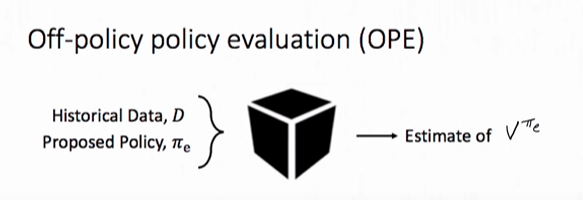 <br>
_Figure 1. Off-policy evaluation pipeline._

Towards creating a safe batch RL algorithm,
* __Off-policy policy eval (OPE)__
    * for any evaluation policy $V^{\pi_{e}}$, convert historical data $D$ into $n$ independent and unbiased estimates of $V^{\pi_{e}}$
* __High-confidence off-policy policy eval (HCOPE)__
    * confidence bound on how well our policy performs 
* __Safe Policy Improvement (SPI) (control)__
    * use HCOPE to create a safe batch RL algorithm

## 2.1. Off Policy Evaluation

Here we are talking about MC policy evaluation again! The last time we talked about something like this, as far as I can remember were Lectures 3 & 4. Then, we looked into model-free MC Policy evaluation. Here, we consider it in the off-policy setting.

The aim is to estimate the values for your offline policy from your behavioral policy (the exploration policy).

The problem in off policy eval is the __distribution mismatch__ (one policy generated the data, and another will most definitely act differently).

Note that this is all off-policy evaluation. Policy control is the same as before (or so I assume!). 

### 2.1.1. Importance Sampling

To counter this we can use __importance sampling (IS)__ (Eq. 2) or __weighted importance sampling (WIS)__ (Eq. 3). First we look at importance sampling:

$$
\begin{equation}
    \begin{split}
        IS(D) = \mathbb{E}_{x \sim q}[f(x)] & = \int_{x} q(x)f(x) dx\\
        & = \frac{1}{n} \sum_{i} \frac{q(x_{i})}{p(x_{i})}f(x_{i})\\
        & = \frac{1}{n} \sum_{i}^{n} w_{i} (\sum_{t = 1}^{L} \gamma^{t}R_{t}^{i})
    \end{split}
\end{equation} \hspace{1em} (Eq.~2)\\
WIS(D) = \frac{1}{\sum_{i = 1}^{n}w_{i}}\sum_{i = 1}^{n}w_{i}(\sum_{t = 1}^{L}\gamma^{t}R_{t}^{i}) \hspace{1em} (Eq.~3)\\
$$

Here $w_{i}$ is equivalent to $\frac{q(x_{i})}{p(x_{i})}$.

This function is very generalized (not specific to RL at all). It estimates the expected value of a function $f(x)$ under some probability distribution $p(x)$: $\mathbb{E}_{x \sim p}[f(x)]$. Data $x_{1},..., x_{n}$ sampled from distribution $q(s)$.

In the RL setting, the probability of a trajectory is written as:

$$
p(h_{j}~|~\pi, s = s_{j, 1}) = \prod_{t = 1}^{L_{j} - 1} \pi(a_{j, t}~|~s_{j, t}) p(r_{j, t}~|~s_{j, t}, a_{j, t}) p(s_{j, t + 1}~|~s_{j, t}, a_{j, t}) \hspace{1em} (Eq.~4)\\
$$

Eq. 3 is the probability of a history $j$ given the exploration policy and the initial state. 

$$
\begin{equation}
    \begin{split}
        V^{\pi_{1}}(s) & \approx \frac{1}{n} \sum_{j = 1}^{n} \frac{p(h_{j}~|~\pi_{1}, s)}{p(h_{j}~|~\pi_{2}, s)} G(h_{j})\\
        & \approx \frac{1}{n} \sum_{i = 1}^{n} (\prod_{t = 1}^{L} \frac{\pi_{e}(a_{t}~|~s_{t})}{\pi_{b}(a_{t}~|~s_{t})}) (\sum_{t = 1}^{L} \gamma^{t}R_{t}^{i})
    \end{split}
\end{equation} \hspace{1em} (Eq.~5)\\
$$

$n$ is the number of episodes and $L$ is the length of an episode. $\pi_{e}$ is the evaluation policy and $\pi_{b}$ is the exploration policy.

Eq. 4 is basically getting the value function for policy $\pi_{1}$ from the data collected by policy $\pi_{2}$. It is the importance sampling idea previously introduced contextualized in RL. 

__Per-decision importance sampling (PDIS)__ is simply importance sampling but with a small rearrangement:

$$
V^{\pi_{1}}(s) = PDIS(D) = \sum_{t = 1}^{L} \gamma^{t} \frac{1}{n} \sum_{i = 1}^{n} (\prod_{\tau = 1}^{t} \frac{\pi_{e}(a_{\tau}~|~s_{\tau})}{\pi_{b}(a_{\tau}~|~s_{\tau})}) R_{t}^{i} \hspace{1em} (Eq.~6)\\
$$

Notice how in PDIS (Eq. 5) the summation over the length of the episode $L$ with gamma is brought to the front. 

We understand this equation as: for every time step $t$ up to $L$, multiply the discount factor $\gamma$ at time step $t$ by the reward and the average product ratio of $\pi_{e}$'s probability to take a specified action given a state to $\pi_{b}$'s probability for that same action and state.

### 2.1.2. Control Variates

Consider the following scenario:

$X, Y, \mathbb{E}[Y]$ are random variables. <br>
$\mu = \mathbb{E}[X]$ <br>
$\hat{\mu} = X - Y | \mathbb{E}[Y]$ <br>
$\mathbb{\hat{\mu}} = \mathbb{E}[X - Y + \mathbb{E}[Y]] = \mathbb{E}[X] - \mathbb{E}[Y] + \mathbb{E}[Y] = \mathbb{E}[X] = \mu$ <br>
$Var(\hat{\mu}) = Var(X - Y + \mathbb{E}[Y]) = Var(X - Y)$ <br>

What does this tell us? We can control the variance while preserving the mean. This idea was seen before in using _baselines_ in policy gradient estimation.

We can combine this idea of __control variates__ with importance sampling to get a __doubly robust estimator__ which is robust to the issues from a poor approximate model and errors in estimates of $\pi_{b}$. The equation is shown below:

$$
w_{t}^{i} = \prod_{\tau = 1}^{t} \frac{\pi_{e}(a_{\tau}~|~s_{\tau})}{\pi_{b}(a_{\tau}~|~s_{\tau})}\\
DR(\pi_{e}~|~D) = \frac{1}{n} \sum_{i = 1}^{n} \sum_{t = 0}^{\infty} \gamma^{t}w_{t}^{i}(R_{t}^{i} - \hat{q}^{\pi_{e}}(S_{t}^{i}, A_{t}^{i})) + \gamma^{t} p_{t - 1}^{i}\hat{v}^{\pi_{e}}(S_{t}^{i}) \hspace{1em} (Eq.~7)\\ 
$$

## 2.2. High Confidence Off Policy Policy Evaluation

In $w_{t}^{i}$ in the previous section, $\pi_{b}$ can be extremely small. If this is the case, then the ratio is extremely large, and because we consider the product from $\tau = 1$ to $t$, the resulting weight is extremely large.

We want to establish a high confidence bound when evaluating our policy. 

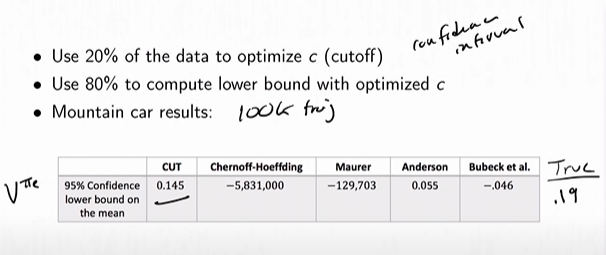 <br>
_Figure 2. Finding the 95% confidence interval lower bound for policy evaluation._

Basically, the CUT method ranks the best among the other methods in estimating the lower bound for how well the offline policy performs.

## 2.3. Safe Policy Improvement

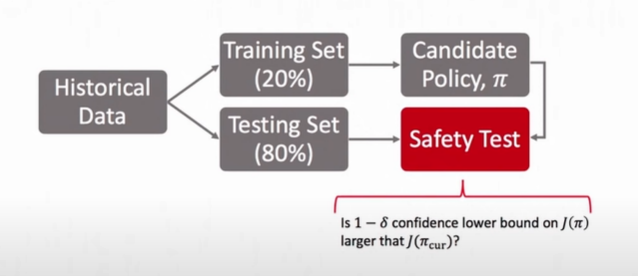 <br>
_Figure 3. Safe Policy Improvement Pipeline._

Figure 3 shows a general pipeline for how we can take historical data and produce a policy fit for the real world. There are a lot of real world factors to consider when deploying a policy and a lot of the times, it primarily depends on the domain.

# 5. Resource

If you missed the link right below the title, I'm providing the resource here again along with the course website.

- [Stanford CS234](https://www.youtube.com/watch?v=FgzM3zpZ55o)
- [Course Website](http://web.stanford.edu/class/cs234/index.html)

This is a series of 15 lectures provided by Stanford.
